In [10]:
from qiskit import QuantumCircuit, Aer
from qiskit.opflow import X, Y, Z, I, CircuitStateFn, CircuitSampler, MatrixExpectation, PauliExpectation, StateFn, AerPauliExpectation
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector, Parameter
import numpy as np

backend = Aer.get_backend('qasm_simulator') 
q_instance = QuantumInstance(backend, shots=1024)

In [2]:
# but here we'll use the H2-molecule Hamiltonian
op =  (-1.0523732 * I^I) + (0.39793742 * I^Z) + (-0.3979374 * Z^I) \
    + (-0.0112801 * Z^Z) + (0.18093119 * X^X)

# define the state you w.r.t. which you want the expectation value
ansatz = QuantumCircuit(2)
ansatz.x(0)
ansatz.x(1)

# convert to a state
ansatz = CircuitStateFn(ansatz)

In [3]:
# define the state to sample
measurable_expression = StateFn(op, is_measurement=True).compose(ansatz) 

In [4]:
expectation = PauliExpectation().convert(measurable_expression)
sampler = CircuitSampler(q_instance).convert(expectation)
print('Snapshot:', sampler.eval().real) 

Snapshot: -1.070367563378906


In [5]:
expectation = AerPauliExpectation().convert(measurable_expression)
sampler = CircuitSampler(backend).convert(expectation)  
print('Snapshot:', sampler.eval().real) 

Snapshot: -1.0636533199999998


In [6]:
expectation = MatrixExpectation().convert(measurable_expression)
sampler = CircuitSampler(backend).convert(expectation)  
print('Matrix:', sampler.eval().real) 

Matrix: -1.0636533199999998


# Parameterized Expectation

In [11]:
# DEVICE
backend = Aer.get_backend('qasm_simulator') 
q_instance = QuantumInstance(backend, shots=1024)
# HAMILTONIAN
op = Z^I^I^I + I^Z^I^I + I^I^Z^I + I^I^I^Z

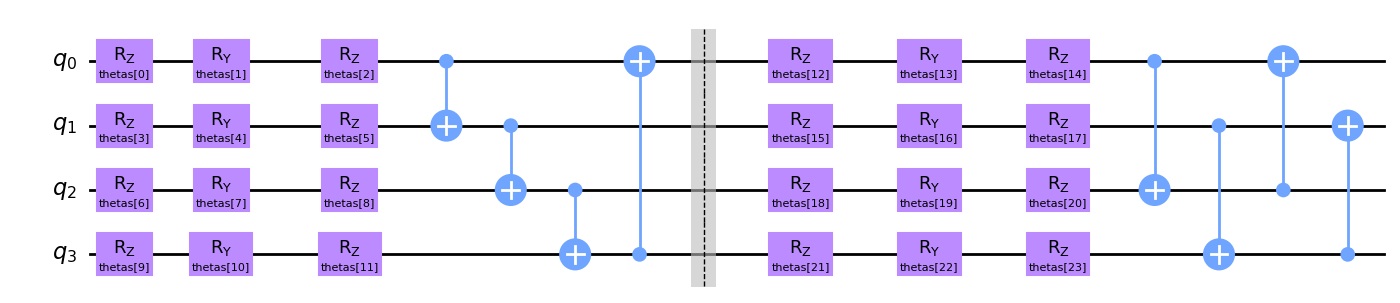

In [12]:
# ANSTAZ
thetas = ParameterVector('thetas', 24)
ansatz = QuantumCircuit(4)
for i in range(4):
    ansatz.rz(thetas[3*i], i)
    ansatz.ry(thetas[3*i+1], i)
    ansatz.rz(thetas[3*i+2], i)
for i in range(4):
    ansatz.cx(i, (i+1)%4)
ansatz.barrier()
for i in range(4):
    ansatz.rz(thetas[3*i+12], i)
    ansatz.ry(thetas[3*i+13], i)
    ansatz.rz(thetas[3*i+14], i)
for i in range(4):
    ansatz.cx(i, (i+2)%4)

ansatz.draw('mpl')

In [24]:
def evaluate_expectation(params):
    psi = ansatz.bind_parameters({thetas: params})
    psi_statefn = CircuitStateFn(psi)
    measurable_expression = StateFn(op, is_measurement=True).compose(psi_statefn) 
    # measurable_expression = StateFn(op, is_measurement=True) @ CircuitStateFn(psi)
    expectation = PauliExpectation().convert(measurable_expression)
    sampler = CircuitSampler(q_instance).convert(expectation)
    return sampler.eval().real

In [14]:
import pickle as pk
with open("Z4/bad-points.pkl", "rb") as fd:
    bad_points = pk.load(fd)
from vqa import Z4
A = Z4()
bad_result = A(bad_points[0])
bad_result[1]

-1.999953065153489

In [30]:
evaluate_expectation(bad_result[2].flatten().numpy())

-6.671875000000001

In [111]:
from qiskit.algorithms.optimizers import GradientDescent
gd = GradientDescent(maxiter=300, learning_rate=0.01)

In [112]:
initial_param = np.random.uniform(0, 2*np.pi, 24)
result = gd.minimize(
    fun=evaluate_expectation,
    x0=initial_param
)

KeyboardInterrupt: 